In [1]:
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Activation, Lambda
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from config_reader import config_reader
import scipy
import math

Using TensorFlow backend.


Helper functions to create a model

In [2]:
def relu(x): 
    return Activation('relu')(x)

def conv(x, nf, ks, name):
    x1 = Conv2D(nf, (ks, ks), padding='same', name=name)(x)
    return x1

def pooling(x, ks, st, name):
    x = MaxPooling2D((ks, ks), strides=(st, st), name=name)(x)
    return x

def vgg_block(x):
     
    # Block 1
    x = conv(x, 64, 3, "conv1_1")
    x = relu(x)
    x = conv(x, 64, 3, "conv1_2")
    x = relu(x)
    x = pooling(x, 2, 2, "pool1_1")

    # Block 2
    x = conv(x, 128, 3, "conv2_1")
    x = relu(x)
    x = conv(x, 128, 3, "conv2_2")
    x = relu(x)
    x = pooling(x, 2, 2, "pool2_1")
    
    # Block 3
    x = conv(x, 256, 3, "conv3_1")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_2")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_3")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_4")
    x = relu(x)    
    x = pooling(x, 2, 2, "pool3_1")
    
    # Block 4
    x = conv(x, 512, 3, "conv4_1")
    x = relu(x)    
    x = conv(x, 512, 3, "conv4_2")
    x = relu(x)    
    
    # Additional non vgg layers
    x = conv(x, 256, 3, "conv4_3_CPM")
    x = relu(x)
    x = conv(x, 128, 3, "conv4_4_CPM")
    x = relu(x)
    
    return x

def stage1_block(x, num_p, branch):
    
    # Block 1        
    x = conv(x, 128, 3, "conv5_1_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 128, 3, "conv5_2_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 128, 3, "conv5_3_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 512, 1, "conv5_4_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, num_p, 1, "conv5_5_CPM_L%d" % branch)
    
    return x

def stageT_block(x, num_p, stage, branch):
        
    # Block 1        
    x = conv(x, 128, 7, "Mconv1_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv2_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv3_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv4_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv5_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 1, "Mconv6_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, num_p, 1, "Mconv7_stage%d_L%d" % (stage, branch))
    
    return x

Create keras model and load weights

In [3]:
weights_path = "model/keras/model.h5" # orginal weights converted from caffe
#weights_path = "training/weights.best.h5" # weights tarined from scratch 

input_shape = (None,None,3)

img_input = Input(shape=input_shape)

stages = 6
np_branch1 = 38
np_branch2 = 19

img_normalized = Lambda(lambda x: x / 256 - 0.5)(img_input)  # [-0.5, 0.5]

# VGG
stage0_out = vgg_block(img_normalized)

# stage 1
stage1_branch1_out = stage1_block(stage0_out, np_branch1, 1)
stage1_branch2_out = stage1_block(stage0_out, np_branch2, 2)
x = Concatenate()([stage1_branch1_out, stage1_branch2_out, stage0_out])

# stage t >= 2
for sn in range(2, stages + 1):
    stageT_branch1_out = stageT_block(x, np_branch1, sn, 1)
    stageT_branch2_out = stageT_block(x, np_branch2, sn, 2)
    if (sn < stages):
        x = Concatenate()([stageT_branch1_out, stageT_branch2_out, stage0_out])

model = Model(img_input, [stageT_branch1_out, stageT_branch2_out])
model.load_weights(weights_path)

W0623 04:15:12.587127  5460 deprecation_wrapper.py:119] From C:\Users\asoma\Anaconda3\lib\site-packages\keras-2.2.4-py3.7.egg\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0623 04:15:12.612059  5460 deprecation_wrapper.py:119] From C:\Users\asoma\Anaconda3\lib\site-packages\keras-2.2.4-py3.7.egg\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0623 04:15:12.625025  5460 deprecation_wrapper.py:119] From C:\Users\asoma\Anaconda3\lib\site-packages\keras-2.2.4-py3.7.egg\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0623 04:15:12.671901  5460 deprecation_wrapper.py:119] From C:\Users\asoma\Anaconda3\lib\site-packages\keras-2.2.4-py3.7.egg\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d i

Load a sample image

In [179]:
%matplotlib inline
import cv2
import matplotlib
import pylab as plt
import numpy as np
import util

In [180]:
util.__file__

'C:\\Users\\asoma\\Documents\\PHOTOHACK\\MODELS\\keras_Realtime_Multi-Person_Pose_Estimation-master\\util.py'

(577, 433, 3)

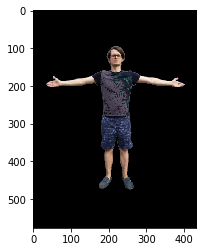

In [135]:
test_image = 'sample_images/stas3.png'
workImg = cv2.imread(test_image, cv2.IMREAD_UNCHANGED) # B,G,R order
workImg = cv2.cvtColor(workImg, cv2.COLOR_RGBA2BGRA)
oriImg = cv2.cvtColor(workImg, cv2.COLOR_RGBA2BGR)
plt.imshow(oriImg[:,:,[2,1,0]])
oriImg.shape
#plt.imshow(workImg)

Load configuration

In [136]:
param, model_params = config_reader()

multiplier = [x * model_params['boxsize'] / oriImg.shape[0] for x in param['scale_search']]

Show sample heatmaps for right elbow and paf for right wrist and right elbow

Input shape: (1, 184, 144, 3)
Output shape (heatmap): (1, 23, 18, 19)
Input shape: (1, 368, 280, 3)
Output shape (heatmap): (1, 46, 35, 19)
Input shape: (1, 552, 416, 3)
Output shape (heatmap): (1, 69, 52, 19)
Input shape: (1, 736, 552, 3)
Output shape (heatmap): (1, 92, 69, 19)


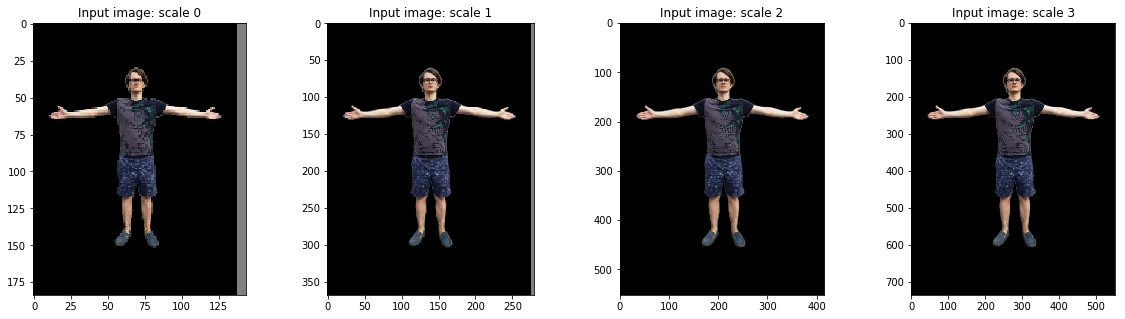

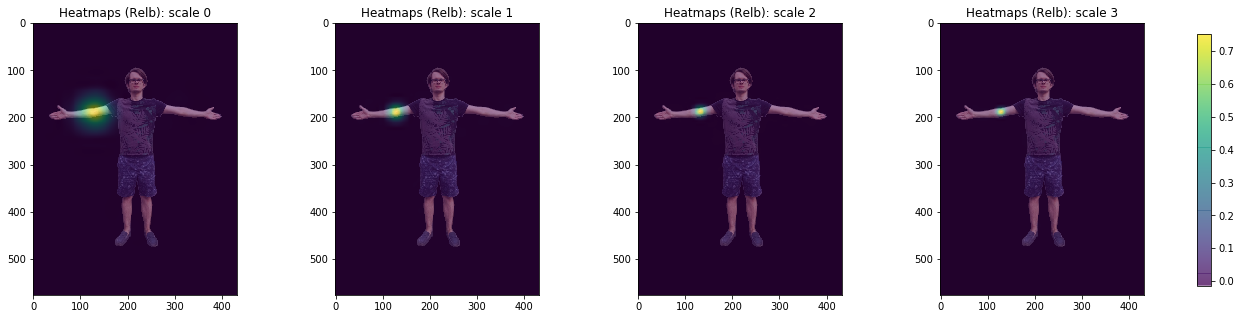

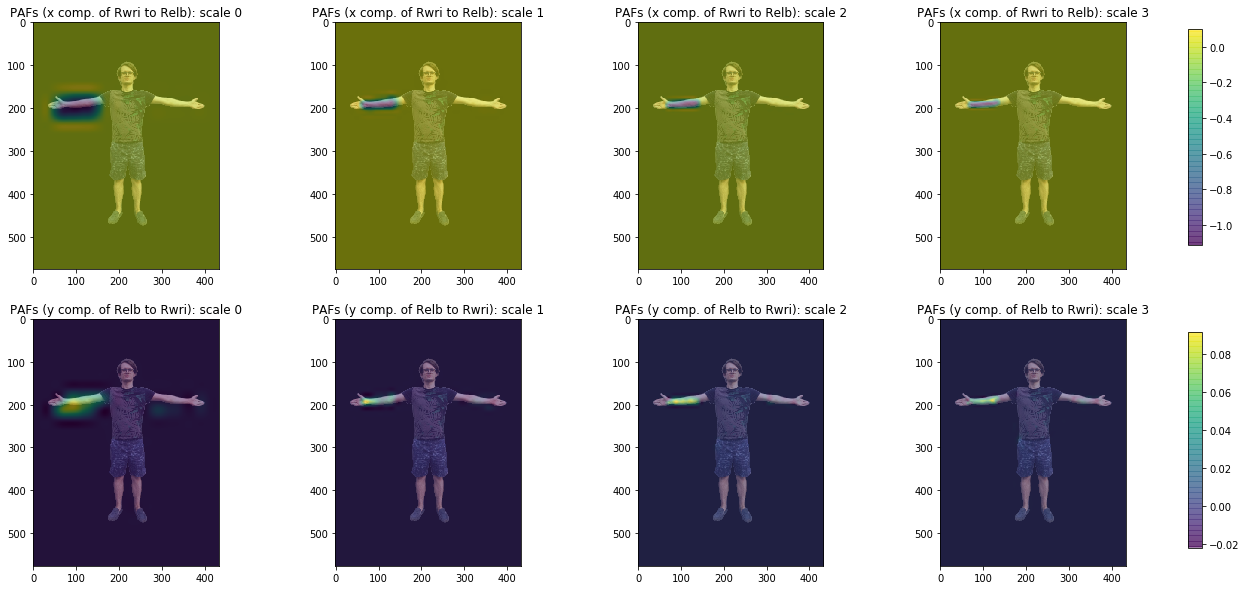

In [137]:
heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))
paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))
# first figure shows padded images
f, axarr = plt.subplots(1, len(multiplier))
f.set_size_inches((20, 5))
# second figure shows heatmaps
f2, axarr2 = plt.subplots(1, len(multiplier))
f2.set_size_inches((20, 5))
# third figure shows PAFs
f3, axarr3 = plt.subplots(2, len(multiplier))
f3.set_size_inches((20, 10))

for m in range(len(multiplier)):
    scale = multiplier[m]
    imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model_params['stride'], model_params['padValue'])        
    axarr[m].imshow(imageToTest_padded[:,:,[2,1,0]])
    axarr[m].set_title('Input image: scale %d' % m)

    input_img = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,0,1,2)) # required shape (1, width, height, channels) 
    print("Input shape: " + str(input_img.shape))  

    output_blobs = model.predict(input_img)
    print("Output shape (heatmap): " + str(output_blobs[1].shape))
    
    # extract outputs, resize, and remove padding
    heatmap = np.squeeze(output_blobs[1]) # output 1 is heatmaps
    heatmap = cv2.resize(heatmap, (0,0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
    heatmap = heatmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
    heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
    
    paf = np.squeeze(output_blobs[0]) # output 0 is PAFs
    paf = cv2.resize(paf, (0,0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
    paf = paf[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
    paf = cv2.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
    
    # visualization
    axarr2[m].imshow(oriImg[:,:,[2,1,0]])
    ax2 = axarr2[m].imshow(heatmap[:,:,3], alpha=.5) # right elbow
    axarr2[m].set_title('Heatmaps (Relb): scale %d' % m)
    
    axarr3.flat[m].imshow(oriImg[:,:,[2,1,0]])
    ax3x = axarr3.flat[m].imshow(paf[:,:,16], alpha=.5) # right elbow
    axarr3.flat[m].set_title('PAFs (x comp. of Rwri to Relb): scale %d' % m)
    axarr3.flat[len(multiplier) + m].imshow(oriImg[:,:,[2,1,0]])
    ax3y = axarr3.flat[len(multiplier) + m].imshow(paf[:,:,17], alpha=.5) # right wrist
    axarr3.flat[len(multiplier) + m].set_title('PAFs (y comp. of Relb to Rwri): scale %d' % m)
    
    heatmap_avg = heatmap_avg + heatmap / len(multiplier)
    paf_avg = paf_avg + paf / len(multiplier)

f2.subplots_adjust(right=0.93)
cbar_ax = f2.add_axes([0.95, 0.15, 0.01, 0.7])
_ = f2.colorbar(ax2, cax=cbar_ax)

f3.subplots_adjust(right=0.93)
cbar_axx = f3.add_axes([0.95, 0.57, 0.01, 0.3])
_ = f3.colorbar(ax3x, cax=cbar_axx)
cbar_axy = f3.add_axes([0.95, 0.15, 0.01, 0.3])
_ = f3.colorbar(ax3y, cax=cbar_axy)

Heatmap for right knee. Note that the body part is encoded in the 3th channel so in this case right knee is 
at index 9. All body parts are defined in config: 
part_str = [nose, neck, Rsho, Relb, Rwri, Lsho, Lelb, Lwri, Rhip, Rkne, Rank, Lhip, Lkne, Lank, Leye, Reye, Lear, Rear, pt19]

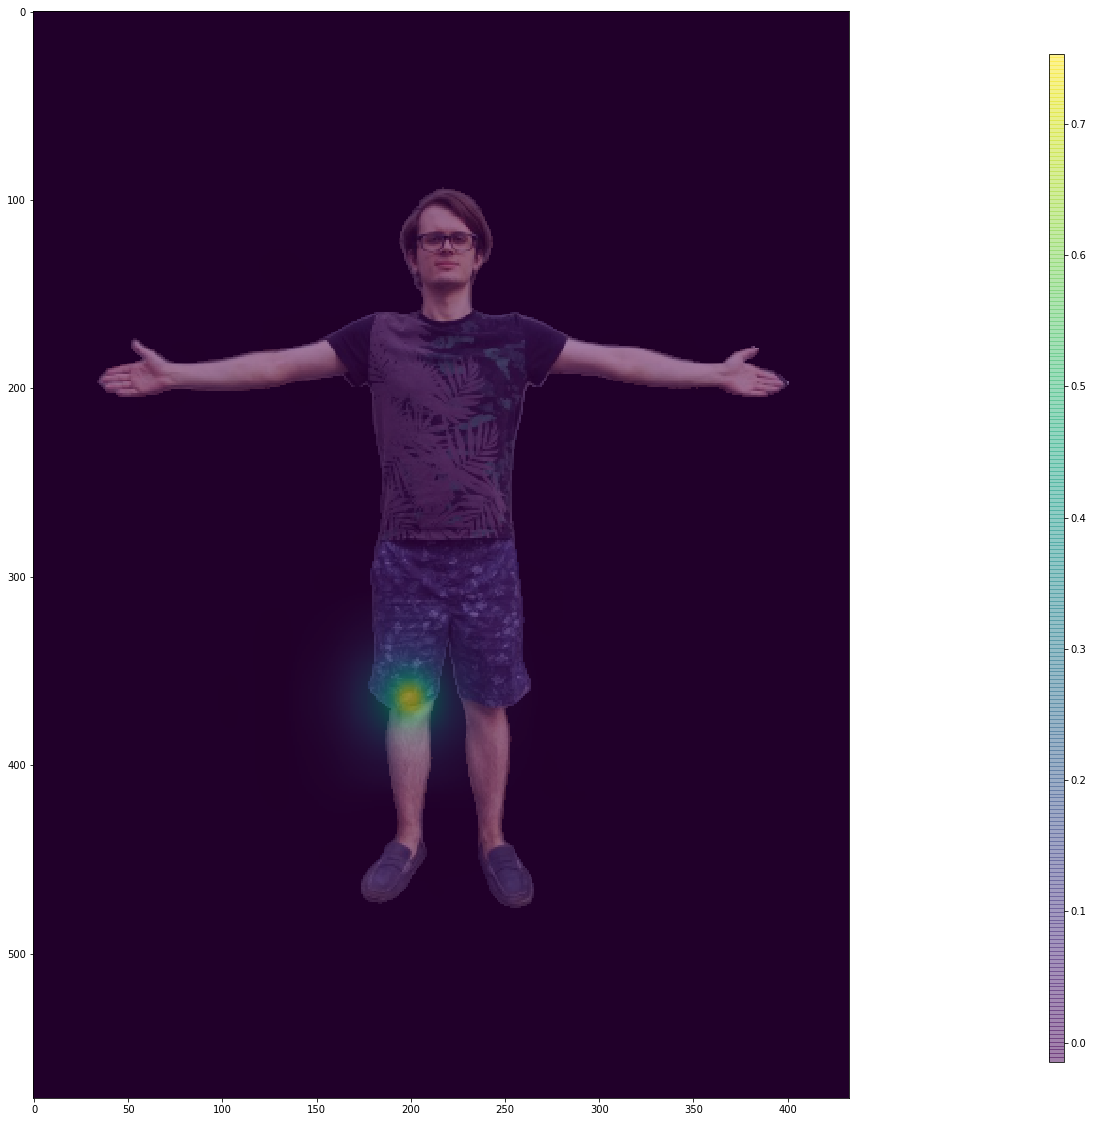

In [138]:
plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(heatmap_avg[:,:,9], alpha=.5)
fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(20, 20)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
_ = fig.colorbar(ax2, cax=cbar_ax)

paf vectors for right elbow and right wrist

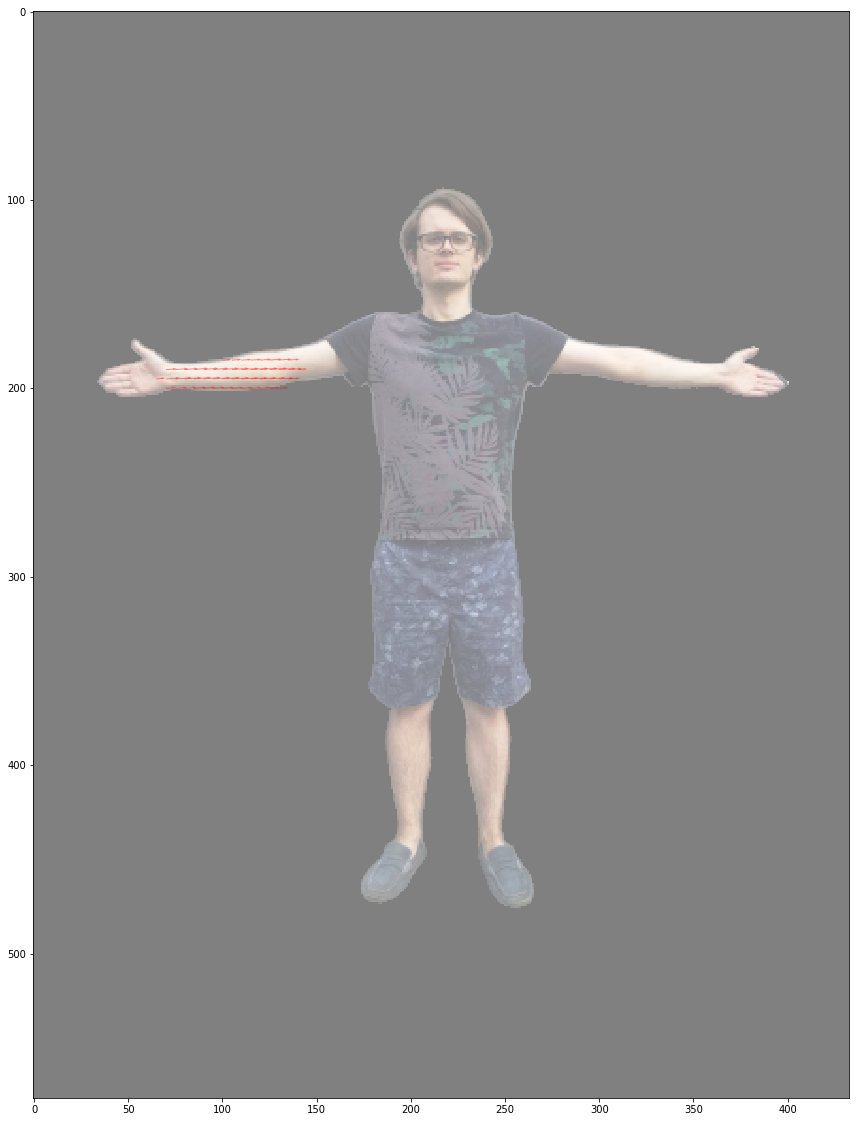

In [139]:
from numpy import ma
U = paf_avg[:,:,16] * -1
V = paf_avg[:,:,17]
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
M = np.zeros(U.shape, dtype='bool')
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

# 1
plt.figure()
plt.imshow(oriImg[:,:,[2,1,0]], alpha = .5)
s = 5
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)

Visualise all detected body parts. Note that we use peaks in heatmaps

In [140]:
from scipy.ndimage.filters import gaussian_filter
all_peaks = []
peak_counter = 0

for part in range(19-1):
    map_ori = heatmap_avg[:,:,part]
    map = gaussian_filter(map_ori, sigma=3)
    
    map_left = np.zeros(map.shape)
    map_left[1:,:] = map[:-1,:]
    map_right = np.zeros(map.shape)
    map_right[:-1,:] = map[1:,:]
    map_up = np.zeros(map.shape)
    map_up[:,1:] = map[:,:-1]
    map_down = np.zeros(map.shape)
    map_down[:,:-1] = map[:,1:]
    
    peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > param['thre1']))
    peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0])) # note reverse
    peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
    id = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)

In [141]:
# find connection in the specified sequence, center 29 is in the position 15
limbSeq = [[2,3], [2,6], [3,4], [4,5], [6,7], [7,8], [2,9], [9,10], \
           [10,11], [2,12], [12,13], [13,14], [2,1], [1,15], [15,17], \
           [1,16], [16,18], [3,17], [6,18]]
# the middle joints heatmap correpondence
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], [19,20], [21,22], \
          [23,24], [25,26], [27,28], [29,30], [47,48], [49,50], [53,54], [51,52], \
          [55,56], [37,38], [45,46]]

In [142]:
connection_all = []
special_k = []
mid_num = 10

for k in range(len(mapIdx)):
    score_mid = paf_avg[:,:,[x-19 for x in mapIdx[k]]]
    candA = all_peaks[limbSeq[k][0]-1]
    candB = all_peaks[limbSeq[k][1]-1]
    nA = len(candA)
    nB = len(candB)
    indexA, indexB = limbSeq[k]
    if(nA != 0 and nB != 0):
        connection_candidate = []
        for i in range(nA):
            for j in range(nB):
                vec = np.subtract(candB[j][:2], candA[i][:2])
                norm = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
                # failure case when 2 body parts overlaps
                if norm == 0:
                    continue
                vec = np.divide(vec, norm)
                
                startend = list(zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                               np.linspace(candA[i][1], candB[j][1], num=mid_num)))
                
                vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                                  for I in range(len(startend))])
                vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                                  for I in range(len(startend))])

                score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                score_with_dist_prior = sum(score_midpts)/len(score_midpts) + min(0.5*oriImg.shape[0]/norm-1, 0)
                criterion1 = len(np.nonzero(score_midpts > param['thre2'])[0]) > 0.8 * len(score_midpts)
                criterion2 = score_with_dist_prior > 0
                if criterion1 and criterion2:
                    connection_candidate.append([i, j, score_with_dist_prior, score_with_dist_prior+candA[i][2]+candB[j][2]])

        connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
        connection = np.zeros((0,5))
        for c in range(len(connection_candidate)):
            i,j,s = connection_candidate[c][0:3]
            if(i not in connection[:,3] and j not in connection[:,4]):
                connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                if(len(connection) >= min(nA, nB)):
                    break

        connection_all.append(connection)
    else:
        special_k.append(k)
        connection_all.append([])

In [143]:
# last number in each row is the total parts number of that person
# the second last number in each row is the score of the overall configuration
subset = -1 * np.ones((0, 20))
candidate = np.array([item for sublist in all_peaks for item in sublist])

for k in range(len(mapIdx)):
    if k not in special_k:
        partAs = connection_all[k][:,0]
        partBs = connection_all[k][:,1]
        indexA, indexB = np.array(limbSeq[k]) - 1

        for i in range(len(connection_all[k])): #= 1:size(temp,1)
            found = 0
            subset_idx = [-1, -1]
            for j in range(len(subset)): #1:size(subset,1):
                if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                    subset_idx[found] = j
                    found += 1
            
            if found == 1:
                j = subset_idx[0]
                if(subset[j][indexB] != partBs[i]):
                    subset[j][indexB] = partBs[i]
                    subset[j][-1] += 1
                    subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
            elif found == 2: # if found 2 and disjoint, merge them
                j1, j2 = subset_idx
                print ("found = 2")
                membership = ((subset[j1]>=0).astype(int) + (subset[j2]>=0).astype(int))[:-2]
                if len(np.nonzero(membership == 2)[0]) == 0: #merge
                    subset[j1][:-2] += (subset[j2][:-2] + 1)
                    subset[j1][-2:] += subset[j2][-2:]
                    subset[j1][-2] += connection_all[k][i][2]
                    subset = np.delete(subset, j2, 0)
                else: # as like found == 1
                    subset[j1][indexB] = partBs[i]
                    subset[j1][-1] += 1
                    subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

            # if find no partA in the subset, create a new subset
            elif not found and k < 17:
                row = -1 * np.ones(20)
                row[indexA] = partAs[i]
                row[indexB] = partBs[i]
                row[-1] = 2
                row[-2] = sum(candidate[connection_all[k][i,:2].astype(int), 2]) + connection_all[k][i][2]
                subset = np.vstack([subset, row])

In [144]:
# delete some rows of subset which has few parts occur
deleteIdx = [];
for i in range(len(subset)):
    if subset[i][-1] < 4 or subset[i][-2]/subset[i][-1] < 0.4:
        deleteIdx.append(i)
subset = np.delete(subset, deleteIdx, axis=0)

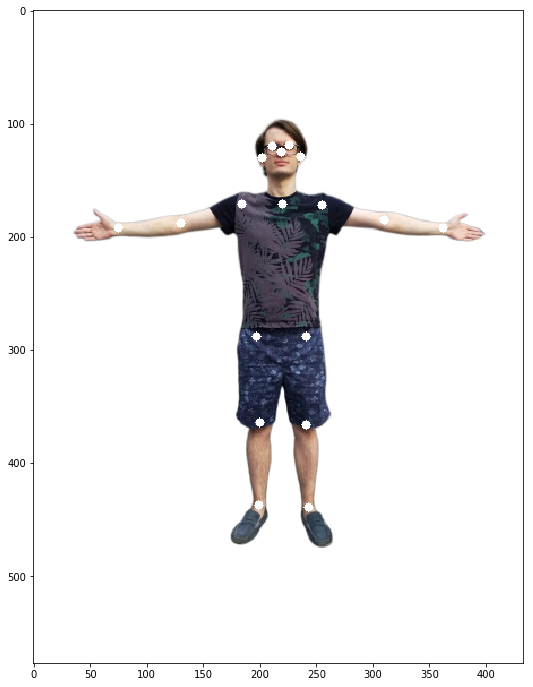

In [145]:
# visualize
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
cmap = matplotlib.cm.get_cmap('hsv')

#canvas = cv2.imread(test_image) # B,G,R order
canvas = workImg.copy()

for i in range(18):
    rgba = np.array(cmap(1 - i/18. - 1./36))
    rgba[0:3] *= 255
    for j in range(len(all_peaks[i])):
        cv2.circle(canvas, all_peaks[i][j][0:2], 4, colors[i], thickness=-1)

#to_plot = cv2.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
#plt.imshow(to_plot[:,:,[2,1,0]])
plt.imshow(canvas)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)

Link body parts

[220. 184.]
[220. 255.]
[184. 130.]
[130.  75.]
[255. 310.]
[310. 362.]
[220. 197.]
[197. 200.]
[200. 199.]
[220. 241.]
[241. 241.]
[241. 243.]
[220. 219.]
[219. 211.]
[211. 202.]
[219. 226.]
[226. 236.]


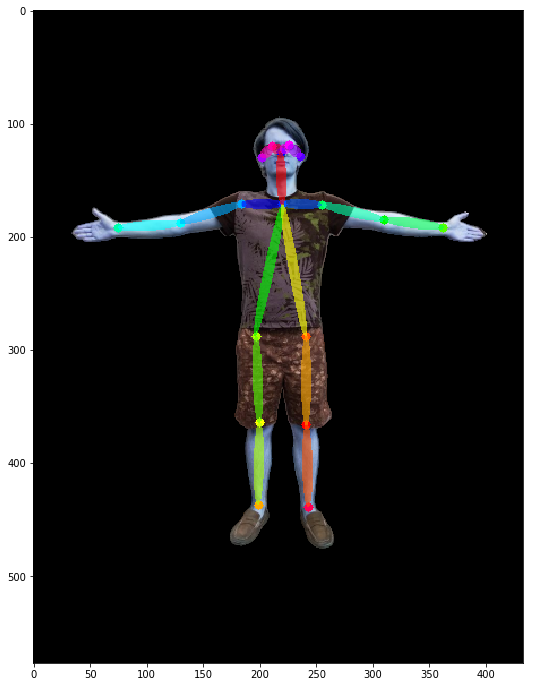

In [146]:
# visualize 2
stickwidth = 4

for i in range(17):
    for n in range(len(subset)):
        index = subset[n][np.array(limbSeq[i])-1]
        if -1 in index:
            continue
        cur_canvas = canvas.copy()
        Y = candidate[index.astype(int), 0]
        print(Y)
        X = candidate[index.astype(int), 1]
        mX = np.mean(X)
        mY = np.mean(Y)
        length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
        angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
        polygon = cv2.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
        cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
        canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
        
plt.imshow(canvas[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)

[171. 125.]
[220. 219.]


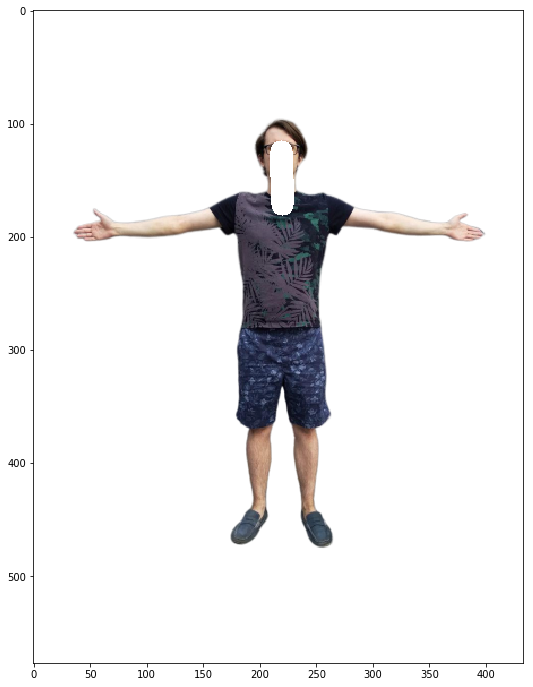

In [147]:
canvas = workImg.copy()
i = 12
for n in range(len(subset)):
    index = subset[n][np.array(limbSeq[i])-1]
    if -1 in index:
        continue
    cur_canvas = canvas.copy()
    Y = candidate[index.astype(int), 0]
    X = candidate[index.astype(int), 1]
    print(X)
    print(Y)
    cv2.line(canvas, (int(Y[0]),int(X[0])),(int(Y[1]),int(X[1])),(250,0,0), 20)
    #for x in range(int(X[0]),int(X[1])):
        #for y in range(int(Y[1]),int(Y[0])):
            #cv2.circle(canvas, (y,x), 4, (50,100,0), thickness=1)
    
        
plt.imshow(canvas)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)

[171. 125.]
[171. 125.]
[171. 125.]
[171. 125.]


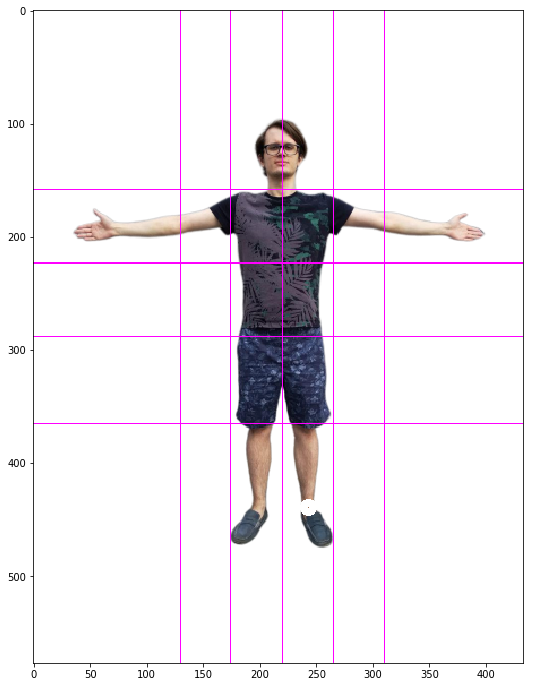

In [148]:
img = workImg.copy()
#Head
index = subset[0][np.array(limbSeq[12])-1]
Y = candidate[index.astype(int), 0]
mY = np.mean(X)+10
print(X)
headline = ((0,int(mY)),(img.shape[1],int(mY)))
cv2.line(img, *headline,color = (255,0,255,255))

#LeftHand
lhandline = ((all_peaks[3][0][0],0),(all_peaks[3][0][0],img.shape[0]))
cv2.line(img, *lhandline,color = (255,0,255,255))

#RightHand
rhandline = ((all_peaks[6][0][0],0),(all_peaks[6][0][0],img.shape[0]))
cv2.line(img, *rhandline,color = (255,0,255,255))

#BottomLine
index = subset[0][np.array(limbSeq[12])-1]
Y = candidate[index.astype(int), 0]
mx = np.mean((all_peaks[11][0][1],all_peaks[8][0][1]))
print(X)
bottomline = ((0,int(mx),),(img.shape[1],int(mx)))
cv2.line(img, *bottomline,color = (255,0,255,255))

#MidLine
index = subset[0][np.array(limbSeq[12])-1]
Y = candidate[index.astype(int), 0]
mx1 = np.mean((all_peaks[10][0][0],all_peaks[9][0][0]))
mx2 = np.mean((all_peaks[12][0][0],all_peaks[13][0][0]))
mx = np.mean((mx1,mx2))
print(X)
midline = ((int(mx),0),(int(mx),img.shape[0]))
cv2.line(img, *midline,color = (255,0,255,255))

#KneeLine
index = subset[0][np.array(limbSeq[12])-1]
Y = candidate[index.astype(int), 0]
mx = np.mean((all_peaks[12][0][1],all_peaks[9][0][1]))
print(X)
kneeline = ((0,int(mx),),(img.shape[1],int(mx),))
cv2.line(img, *kneeline,color = (255,0,255,255))

#LeftSholder
lsholderline = ((all_peaks[2][0][0]-10,0),(all_peaks[2][0][0]-10,img.shape[0]))
cv2.line(img, *lsholderline,color = (255,0,255,255))

#RightSholder
rsholderline = ((all_peaks[5][0][0]+10,0),(all_peaks[5][0][0]+10,img.shape[0]))
cv2.line(img, *rsholderline,color = (255,0,255,255))

#bodymiddleSholder
mx = np.mean((headline[0][1],bottomline[0][1]))
bodymiddle = ((0,int(mx)),(img.shape[1],int(mx)))
cv2.line(img, *bodymiddle,color = (255,0,255,255))

cv2.circle(img, all_peaks[13][0][0:2], 4, (255,255,255), thickness=5)
plt.imshow(img)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)



In [149]:
def calculate_start_angle(x0,y0,x1,y1):
    return math.degrees(math.atan2(x0 - x1, y0 - y1))

def calculate_len(a,b):
    return np.linalg.norm((a[0]-b[0],a[1]-b[1]))

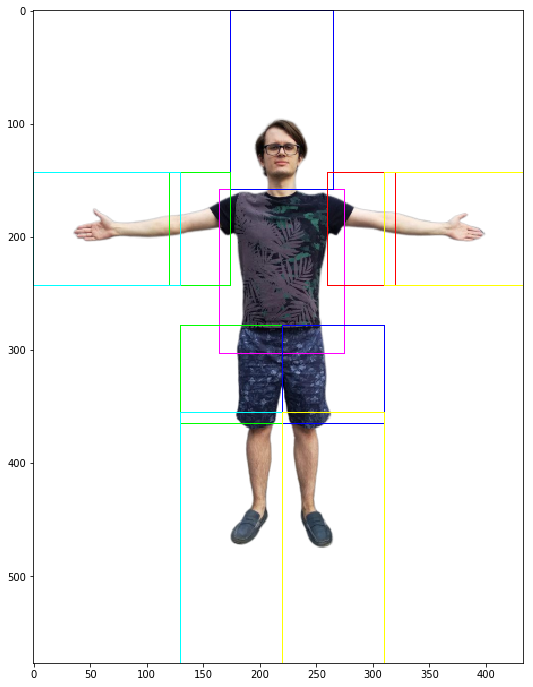

In [150]:
img = workImg.copy()

body = {'rect':((int(lsholderline[0][0]-10),int(headline[0][1])),(int(rsholderline[0][0]+10),int(bottomline[0][1])+15)),
       'pivot':all_peaks[1][0][0:2], 'angle':calculate_start_angle(*all_peaks[1][0][0:2],*all_peaks[0][0][0:2]),
       'length':calculate_len(all_peaks[1][0][0:2],all_peaks[0][0][0:2])}

head = {'rect':((int(lsholderline[0][0]),0),(int(rsholderline[0][0]),int(headline[0][1]))),
        'pivot':all_peaks[1][0][0:2], 'angle':calculate_start_angle(*all_peaks[1][0][0:2],*(midline[0][0],bottomline[0][1])),
       'length':calculate_len(all_peaks[1][0][0:2],(midline[0][0],bottomline[0][1]))}

lsholder = {'rect':((int(lhandline[0][0])-10,int(headline[0][1])-15),(int(lsholderline[0][0]),int(bodymiddle[0][1])+20)),
            'pivot':all_peaks[2][0][0:2], 'angle':calculate_start_angle(*all_peaks[2][0][0:2], *all_peaks[3][0][0:2]),
           'length':calculate_len(all_peaks[2][0][0:2],all_peaks[3][0][0:2])}

rsholder = {'rect':((int(rsholderline[0][0])-5,int(headline[0][1])-15),(int(rhandline[0][0])+10,int(bodymiddle[0][1])+20)),
            'pivot':all_peaks[5][0][0:2],'angle':calculate_start_angle(*all_peaks[5][0][0:2], *all_peaks[6][0][0:2]),
           'length':calculate_len(all_peaks[5][0][0:2],all_peaks[6][0][0:2])}

lhand = {'rect':((0,int(headline[0][1])-15),((int(lhandline[0][0]),int(bodymiddle[0][1])+20))),
         'pivot': all_peaks[3][0][0:2],'angle':calculate_start_angle(*all_peaks[3][0][0:2], *all_peaks[4][0][0:2]),
        'length':calculate_len(all_peaks[3][0][0:2],all_peaks[4][0][0:2])}


rhand = {'rect':((int(rhandline[0][0]),int(headline[0][1])-15),(img.shape[1],int(bodymiddle[0][1])+20)),
        'pivot': all_peaks[6][0][0:2],'angle':calculate_start_angle(*all_peaks[6][0][0:2], *all_peaks[7][0][0:2]),
        'length':calculate_len(all_peaks[6][0][0:2],all_peaks[7][0][0:2])}

lknee = {'rect':((int(lhandline[0][0]),int(bottomline[0][1])-10),(int(midline[0][0]),int(kneeline[0][1]))),
         'pivot':all_peaks[8][0][0:2],'angle':calculate_start_angle(*all_peaks[8][0][0:2], *all_peaks[9][0][0:2]),
        'length':calculate_len(all_peaks[8][0][0:2],all_peaks[9][0][0:2])}

rknee = {'rect':((int(midline[0][0]),int(bottomline[0][1])-10),(int(rhandline[0][0]),int(kneeline[0][1]))),
        'pivot':all_peaks[11][0][0:2],'angle':calculate_start_angle(*all_peaks[11][0][0:2], *all_peaks[12][0][0:2]),
        'length':calculate_len(all_peaks[11][0][0:2],all_peaks[12][0][0:2])}

lleg = {'rect':((int(lhandline[0][0]),int(kneeline[0][1])-10),(int(midline[0][0]),img.shape[0])),
        'pivot':all_peaks[9][0][0:2],'angle':calculate_start_angle(*all_peaks[9][0][0:2], *all_peaks[10][0][0:2]),
       'length':calculate_len(all_peaks[9][0][0:2],all_peaks[10][0][0:2])}

rleg = {'rect':((int(midline[0][0]),int(kneeline[0][1])-10),(int(rhandline[0][0]),img.shape[0])),
        'pivot':all_peaks[12][0][0:2], 'angle':calculate_start_angle(*all_peaks[12][0][0:2], *all_peaks[13][0][0:2]),
       'length':calculate_len(all_peaks[12][0][0:2],all_peaks[13][0][0:2])}

cv2.rectangle(img,*(body['rect']), (255,0,255,255),1)
cv2.rectangle(img,*(head['rect']), (0,0,255,255),1)
cv2.rectangle(img,*(lsholder['rect']), (0,255,0,255),1)
cv2.rectangle(img,*(rsholder['rect']), (255,0,0,255),1)
cv2.rectangle(img,*(lhand['rect']), (0,255,255,255),1)
cv2.rectangle(img,*(rhand['rect']), (255,255,0,255),1)
cv2.rectangle(img,*(lknee['rect']), (0,255,0,255),1)
cv2.rectangle(img,*(rknee['rect']), (0,0,255,255),1)
cv2.rectangle(img,*(lleg['rect']), (0,255,255,255),1)
cv2.rectangle(img,*(rleg['rect']), (255,255,0,255),1)

plt.imshow(img)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)

In [151]:
def get_subregion(img,rect):
    print(rect)
    return img[rect[0][1]:rect[1][1],rect[0][0]:rect[1][0]]

((174, 0), (265, 158))


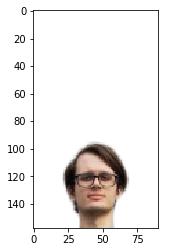

In [152]:
plt.imshow(get_subregion(workImg,head['rect']))

In [157]:
class body_part:
    def __init__(self, img, region_dict, childs = list()):
        temp_img = img.copy()
        temp_img*=0
        temp_img[region_dict['rect'][0][1]:region_dict['rect'][1][1],
                 region_dict['rect'][0][0]:region_dict['rect'][1][0],:] = self.__get_subregion(img,region_dict['rect'])
        self.img = temp_img
        self.childs = childs
        self.pivot = region_dict['pivot']
        self.rect = region_dict['rect']
        self.angle = region_dict['angle']
        self.length = region_dict['length']
        
    def __get_subregion(self,img,rect):
        return img[rect[0][1]:rect[1][1],rect[0][0]:rect[1][0]]
    
    def __update_childs(self):
        end_pos = (self.pivot[0] + np.sin((180+self.angle) * np.pi / 180.)*self.length,
                   self.pivot[1] + np.cos((180+self.angle) * np.pi / 180.)*self.length)
        for child in self.childs:
            child.move(end_pos)
            
    def __rotateImage(self,delta_angle):
        rot_mat = cv2.getRotationMatrix2D(self.pivot, delta_angle, 1.0)
        self.img = cv2.warpAffine(self.img, rot_mat, self.img.shape[1::-1],  borderMode=cv2.BORDER_TRANSPARENT)
        
    def __moveImage(self,delta_pos):
        rows,cols,_ = self.img.shape
        M = np.float32([[1,0,delta_pos[0]],[0,1,delta_pos[1]]])
        self.img = cv2.warpAffine(self.img,M,(cols,rows),borderMode=cv2.BORDER_TRANSPARENT)
     
    def draw(self,output):
        result = np.zeros(output.shape, np.uint8)
        alpha = self.img[:, :, 3] / 255.0
        result[:, :, 0] = (1. - alpha) * output[:, :, 0] + alpha * self.img[:, :, 0]
        result[:, :, 1] = (1. - alpha) * output[:, :, 1] + alpha * self.img[:, :, 1]
        result[:, :, 2] = (1. - alpha) * output[:, :, 2] + alpha * self.img[:, :, 2]
        result[:, :, 3] = np.clip((1. - alpha)*output[:, :, 3] + alpha * self.img[:, :, 3],0,255)
        output = result
        for child in self.childs:
            output = child.draw(output)
        return output
    
    def rotate(self,angle):
        delta_angle = angle - self.angle
        self.angle = angle
        self.__rotateImage(delta_angle)
        self.__update_childs()
    
    def move(self,new_pivot_pos):
        delta = (new_pivot_pos[0] - self.pivot[0], new_pivot_pos[1] - self.pivot[1])
        self.pivot = (self.pivot[0]+delta[0], self.pivot[1]+delta[1])
        self.__moveImage(delta)
        self.__update_childs()
        
        

            

In [172]:
llegBP = body_part(workImg,lleg)
rlegBP = body_part(workImg,rleg)

lkneeBP = body_part(workImg,lknee,[llegBP])
rkneeBP = body_part(workImg,rknee,[rlegBP])

lhandBP = body_part(workImg, lhand)
rhandBP = body_part(workImg, rhand)

lsholderBP = body_part(workImg,lsholder,[lhandBP])
rsholderBP = body_part(workImg,rsholder,[rhandBP])


headBP = body_part(workImg, head)

bodyBP = body_part(workImg,body,[lkneeBP,rkneeBP,headBP,lsholderBP,rsholderBP])

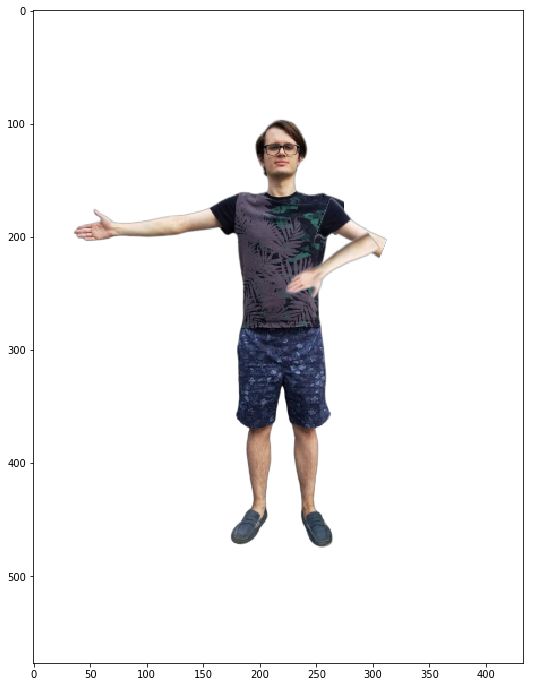

In [173]:
temp_img = workImg.copy()
temp_img*=0

rsholderBP.rotate(-125)
rhandBP.rotate(120)
temp_img = bodyBP.draw(temp_img)
plt.imshow(temp_img)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)